# RRT Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import random

In [22]:
# Define the parameters of the RRT implementation
xdim=10
ydim=10
epsilon=1.0      # Max length of branch
numNodes=1000
goal_region=0.2       

init_x=2.0
init_y=2.0
fin_x=8.0
fin_y=8.0

In [3]:
# Define functions for RRT

#Find the distance between
def dist(p1,p2):
    d=np.sqrt((p2[0]-p1[0])**2+(p2[1]-p1[1])**2)
    return d

# If the edge between two points are longer than epsilon, shorten the edge to match epsilon.
# p2 is the newly sampled random point
def set_edge_pt(p1,p2):
    d=dist(p1,p2)
    if d<epsilon:
        return p2
    else:
        new_pt=(p2-p1)/d*epsilon+p1
        return new_pt

### An implementation of RRT in 2D with no obstacles

Number of nodes: 328


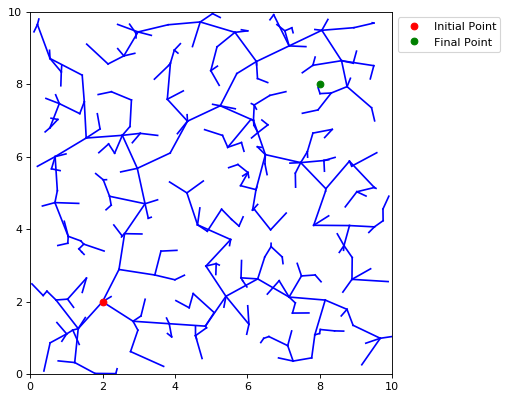

In [27]:
# Initialize the figure
fig=plt.figure(figsize=(8.333,6),dpi=80)
ax=fig.add_subplot(111,autoscale_on=False, xlim=(0, xdim), ylim=(0, ydim))
ax.set_aspect('equal')

# Initialize a list of nodes2
nodes=[]
nodes.append(np.array([init_x,init_y]))

for i in range(numNodes):
    node=nodes[0]
    rand_pt=np.array([random.random()*xdim, random.random()*ydim])
    for p in nodes:
        if dist(p,rand_pt)<dist(node,rand_pt):
            node=p
    new_rand_pt=set_edge_pt(node,rand_pt)
    nodes.append(new_rand_pt)
    ax.plot([node[0], new_rand_pt[0]],[node[1], new_rand_pt[1]],'b-')
    if dist(new_rand_pt,np.array([fin_x,fin_y]))<goal_region:
        break

print('Number of nodes: '+str(i))
        
# Plot the initial and final points
ax.plot(init_x,init_y,'ro',label='Initial Point')
ax.plot(fin_x,fin_y,'go',label='Final Point')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

ax.legend(bbox_to_anchor=(1,1))
plt.show()
    